In [1]:
# Loading required packages
using JuMP
using HiGHS
using LinearAlgebra
using Plots
using Distributions
# Standard libraries
using Statistics
using Random

# Example 4 - Pension Fund Problem

The pension fund of a company must make payments for the next 15 years. The payments are to be covered by investing an initial capital $K$ in bonds of 3 different types. How should the capital be invested to maximize the cash remaining in the fund after 15 years? Let 

- $I=1,\dots,3$ the types of bond
- $J=1,\dots,15$ the payment years
- $x_i$, the number of bonds bought of type $i\in I$
- $\gamma_i$ the price of bond $i \in I$
- $\alpha_{ij}$ yield per bond $i\in I$ in year $j\in J$
- $\beta_j$ payment in year $j\in J$

\begin{align*}
    \max_{x}\; & K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{15}\sum_{i=1}^3\alpha_{ij}x_i - \sum_{j=1}^{15}\beta_j \\
    \text{s.t. } & K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i - \sum_{j=1}^{k}\beta_j \geq 0 \quad \forall k=1,\dots,15
\end{align*}

In [2]:
# data
K = 250000             # initial capital
I = 1:3                # types of bonds
nJ = 15                # number of years
J = 1:nJ               # payment years
γ = [980, 970, 1050]   # price of bonds

β = 10^3 .* [11, 12, 14, 15, 16, 18, 20, 21, 22, 24, 25, 30, 31, 31, 31]    # payments
α = [0 60 60 60 60 1060 0 0 0 0 0 0 0 0 0;                                  # yields of the bonds
     0 65 65 65 65 65 65 65 65 65 65 1060 0 0 0;
     0 75 75 75 75 75 75 75 75 75 75 75 75 75 1075];

First, we implement a deterministic version of the problem.

In [3]:
# implementing the model
m = Model(HiGHS.Optimizer)
set_silent(m)

@variable(m, x[I]) # bond investment decision

# amount of cash in year k
@expression(m, cash[k in J], K - sum(γ[i]*x[i] for i in I) + sum(α[i,j]*x[i] for i in I, j in 1:k) - sum(β[j] for j in 1:k)) 
@constraint(m, [k in J], cash[k] ≥ 0) # liquidity constraint (cash must not be negative)

@objective(m, Max, cash[nJ]) # maximize cash in last year

optimize!(m)

# print solution
x_det    = round.(value.(x), digits=1)
cash_det = round.(value.(cash),digits=1)
println("x = ",               [x_det[i] for i in I])
println("objective value = ", round.(objective_value(m), digits=1))
println("cash = ",            [cash_det[j] for j in J])

x = [31.1, 55.5, 147.3]
objective value = 127332.0
cash = [-0.0, 4522.4, 7044.7, 8567.1, 9089.4, 38721.0, 33376.8, 27032.6, 19688.4, 10344.2, 0.0, 39907.2, 19953.6, -0.0, 127332.0]


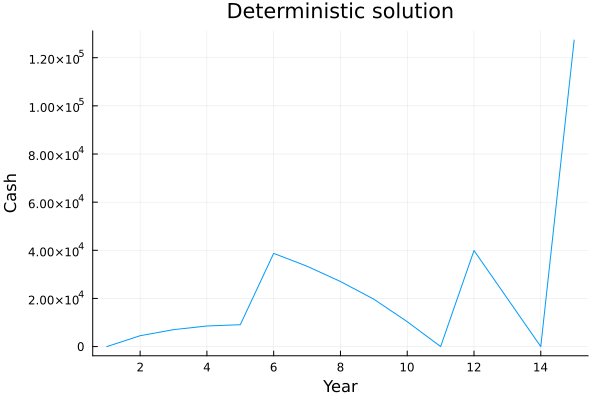

In [4]:
# plot cash amount over the years
plot(1:15, [cash_det[j] for j in J],
    label=false,
    xlabel="Year", 
    ylabel="Cash", 
    title="Deterministic solution")

## Chance Constraints

Now assume that the payments $\beta$ are uncertain. How would the deterministic investment solution $x_{det}$ perform for payment scenarios that differ from the nominal case $\beta$? We will generate some random scenarios with mean $\beta$ and standard deviation $500j$ in year $j$ and take a look.

In [5]:
# Function for scenario generation
function create_scenarios(beta, nS) # beta = nominal demand scenario, nS = number of scenarios

    ## Renaming for making the implementation clearer
    nJ = length(beta)       # number of years/payments
    J  = 1:nJ               # set of payment years
    S  = 1:nS               # scenario set
    P  = repeat([1/nS],nS ) # scenario probability

    ## b_sto: Stochastic payments
    b_sto = zeros(nS,nJ)    

    ## Sampling from a normal distribution with mean 0 and standard deviation 500
    ϵ = rand(Normal(0, 500), nS, nJ)
    
    ## Assigning stochastic values
    for s in S
        b_sto[s,1] = beta[1]
        for j in J[J .> 1]
            # stochastic payment = deterministic mean payment + accumulated perturbance
            b_sto[s,j] = beta[j] + sum(ϵ[s,j1] for j1 in 1:j)
        end
    end
    return b_sto, P
end;

# Function to calculate the amount of cash given a scenario beta, investment decision x and year k
function calculate_cash(beta, x, k) 
    return K - sum(γ[i]*x[i] for i in I) + sum(α[i,j]*x[i] for i in I, j in 1:k) - sum(beta[j] for j in 1:k)
end

# Function to calculate number of violations of liquidity constraint for given cash scenarios
function number_of_violations(cash_scenarios)
    violates   = sort(cash_scenarios .< 0, dims=1, rev=true)    # map negative entries to 1, else 0, then sort 
    n_violates = length(filter(x -> x > 0, violates[1,:]))      # how many ones in the first row?
    return n_violates
end

number_of_violations (generic function with 1 method)

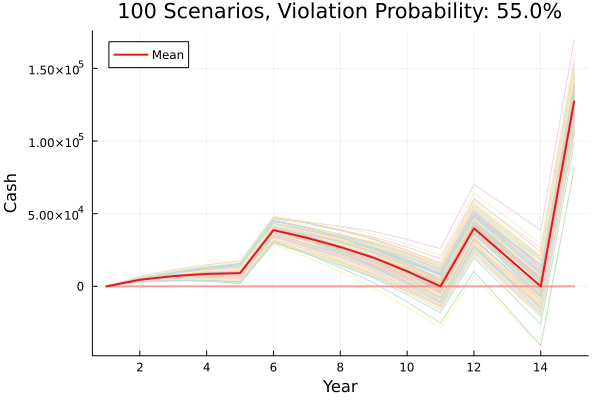

In [13]:
# Generate scenarios
nS = 100
S = 1:nS
β_stoch, β_prob = create_scenarios(β, nS)

# Calculate cash amount in every year
cash_scenarios_det = [calculate_cash(β_stoch[s,:],x_det,j) for j in J, s in S]

# Calculate number of violations of liquidity constraint
n_violations = number_of_violations(cash_scenarios_det)

# Plot
plot(label=false,
    xlabel="Year", 
    ylabel="Cash", 
    title="$(nS) Scenarios, Violation Probability: $(100*n_violations/nS)%")
plot!(cash_scenarios_det, alpha=0.9, label=false, palette=:Pastel2)
plot!(1:nJ, label=false, linewidth=2, palette=:Paired)
plot!([cash_det[j] for j in J], linewidth=2, label="Mean")

As the plot shows, the probability of a scenario violating the liquidity constraint (i.e., cash must be nonnegative) is quite high. To control the probability of a violation, we introduce stochasticity to the model. We assume that the pension payments are random variables $\tilde{\beta}_j, j\in J$ corresponding to an independent normal distribution with mean $\mathbb{E}(\tilde{\beta}_j) = \beta_j$  and variance $500j$ in year $j\in J$. The cumulative payments $\xi_k = \sum_{j=1}^{k}{\tilde{\beta}_j}$ are therefore also normally distributed, with mean $\mu_k = \sum_{j=1}^{k}{(\beta_j)}$ and variance $\sigma_k = \sum_{j=1}^{k}{Var(\tilde{\beta}_j)}$.

\begin{align*}
    \max_{x}\; & K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{15}\sum_{i=1}^3\alpha_{ij}x_i - \color{orange}{ \xi_{15}} \\
    \text{s.t. } & K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i - \color{orange}{\xi_k} \geq 0 \quad \forall k=1,\dots,15
\end{align*}

 The expected value problem, i.e., replacing $\xi$ by its expected value, corresponds to the deterministic version from above. Now, instead of using the liquidity constraints directly, we introduce individual chance constraints which restrict the probability of a constraint violation:
 
\begin{align*}
    P \biggl( K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i - \color{orange}{\xi_k} \geq 0 \biggr) \geq p \quad \forall k=1,\dots,15
\end{align*}

Because we know the mean and variance of the random variable $\xi$, we can reformulate the problem to obtain an equivalent probability of a standard normal distribution:
\begin{align*}
  & P \biggl( K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i &\geq \color{orange}{\xi_k} \biggr) &\geq p \quad \forall k=1,\dots,15 \\
  \Leftrightarrow\quad & P \biggl( \frac{K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i - \mu_k}{\sqrt{\sigma_k}} &\geq \color{orange}{\frac{\xi_k - \mu_k}{\sqrt{\sigma_k}}} \biggr) &\geq p \quad \forall k=1,\dots,15 \\
\end{align*}


The orange term corresponds to a standard normal distribution, so we obtain 
\begin{align*}
  \Leftrightarrow\quad & \frac{K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i - \mu_k}{\sqrt{\sigma_k}} &\geq \; q_p \; = \quad P^{-1}(p) \quad \forall k=1,\dots,15
\end{align*}
where $q_p$ is the $p$-quantile of the standard normal distribution. So, to incorporate the chance constraint, we use in our model the new constraint:
\begin{align*}
  K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i &\geq \color{orange}{q_p \sqrt{\sigma_k}} + \mu_k \quad \forall k=1,\dots,15
\end{align*}
Note: Since $\mu_k = \sum_{j=1}^k \beta_j$ is the term used in the deterministic model, the chance constraint only differs to the deterministic constraint by the highlighted term $q_p\sqrt{\sigma_k}$, which is called the safety term.

In [7]:
σ          = [sum((500*j)^2 for j in 1:k) for k in J] # variance of ξ
p          = 0.95                                     # probability that the constraint is satisfied
quantile_p = quantile.(Normal(), p)                   # p-quantile of the standard normal distribution

# implementing the model
m_chance = Model(HiGHS.Optimizer)
set_silent(m_chance)

@variable(m_chance, x[I])

@expression(m_chance, cash_chance_con[k in J], 
    K - sum(γ[i]*x[i] for i in I) + sum(α[i,j]*x[i] for i in I, j in 1:k) - sum(β[j] for j in 1:k) - quantile_p*sqrt(σ[k]) # chance constraint with safety term
) 

@constraint(m_chance, [k in J], cash_chance_con[k] >= 0)

@objective(m_chance, Max, K - sum(γ[i]*x[i] for i in I) + sum(α[i,j]*x[i] for i in I, j in J) - sum(β[j] for j in J)) # maximize expected value

optimize!(m_chance)

# print solution
x_chance    = round.(value.(x), digits=1)
cash_chance = [calculate_cash(β,x_chance,j) for j in J] # can't use the model expression cash_chance_con, because of the safety term

println("x = ",               [x_chance[i] for i in I])
println("objective value = ", round.(objective_value(m_chance), digits=1))
println("cash = ",            [cash_chance[j] for j in J])

x = [62.8, 72.6, 101.2]
objective value = 103997.6
cash = [774.0, 4851.0, 6928.0, 8005.0, 8082.0, 68959.0, 61268.0, 52577.0, 42886.0, 31195.0, 18504.0, 73050.0, 49640.0, 26230.0, 104020.0]


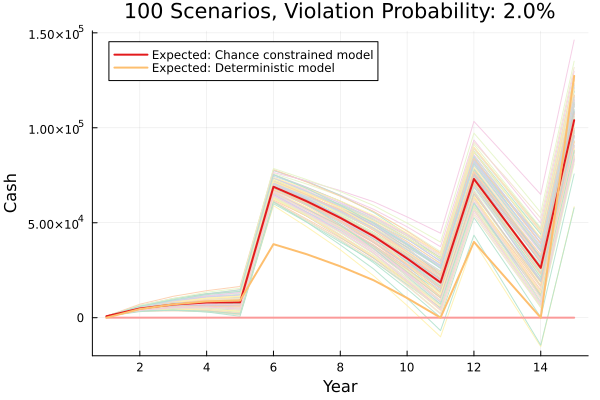

In [16]:
# Calculate cash amount in every year
cash_scenarios_chance = [calculate_cash(β_stoch[s,:], x_chance,j) for j in J, s in S]

# Calculate number of violations of liquidity constraint
n_violations = number_of_violations(cash_scenarios_chance)

# Plot
plot(label=false,
    xlabel="Year", 
    ylabel="Cash", 
    title="$(nS) Scenarios, Violation Probability: $(100*n_violations/nS)%")

plot!(cash_scenarios_chance, alpha=0.9, label=false, palette=:Pastel2)
plot!(1:nJ, label=false, linewidth=2, palette=:Paired)
plot!([cash_chance[j] for j in J], linewidth=2,label="Expected: Chance constrained model")
plot!([cash_det[j] for j in J],    linewidth=2,label="Expected: Deterministic model")

## Scenario-Based Chance Constraints

Normally distributed random variables are a special case. Most of the time, models are based on a set of data, which corresponds to a set of scenarios. Using this directly leads to a scenario-based chance constrained model.
Starting point is the deterministic model:

\begin{align*}
    \max_{x}\; & K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{15}\sum_{i=1}^3\alpha_{ij}x_i - \sum_{j=1}^{15}\beta_j \\
    \text{s.t. } & K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i - \sum_{j=1}^{k}\beta_j \geq 0 \quad \forall k=1,\dots,15
\end{align*}

For the scenario-based chance constraints, we make $\beta$ scenario-dependent, adding a set of constraints for every scenario, and taking the expected value in the objective.

\begin{align*}
    \max_{x}\; & K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{15}\sum_{i=1}^3\alpha_{ij}x_i - \sum_{s\in S}P_s\sum_{j=1}^{15}\beta_j^s
\end{align*}

Then, we add auxiliary variables $u^s, v^s$ to measure and restrict the violation of the individual constraints. 

\begin{align*}
    \text{s.t. }  K - \sum_{i=1}^3\gamma_ix_i + &\sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i - \sum_{j=1}^{k}\beta_j^s + \color{blue}{u_k^s} \geq 0 \quad \forall k=1,\dots,15,\quad\forall s\in S \\
     \;u_k^s &\leq Mv_k^s \quad \forall k=1,\dots,15,\quad\forall s\in S \\
     \sum_{s\in S} P_sv_k^s &\leq 1-p \quad\forall k=1,\dots,15\\
     v_k^s &\in \{0,1\},\; u_k^s \geq 0
\end{align*}

Note: In the model objective we use the expected value of the scenarios, not the "true" expected value $\beta$. In addition, the chance constraints are individual because $u,v$ depend on $k$ - this means, $p$% of scenarios are allowed to violate the constraint per year.

Note 2: notice how long the model takes to be solved. 

In [9]:
# implementing the model
M = 10^6 # big M
m_scen = Model(HiGHS.Optimizer)
set_silent(m_scen)

@variable(m_scen, x[I]) # bond decision
@variable(m_scen, v[s in S, j in J], Bin) # is scenario s violating liquidity constraint j?
@variable(m_scen, u[s in S, j in J] >= 0) # by how much is scenario s violating liquidity constraint j?

@expression(m_scen, cash_scen[s in S, k in J], K - sum(γ[i]*x[i] for i in I) + sum(α[i,j]*x[i] for i in I, j in 1:k) - sum(β_stoch[s,j] for j in 1:k) + u[s,k])

@constraint(m_scen, [k in J, s in S], cash_scen[s,k] >= 0)
@constraint(m_scen, [k in J, s in S], u[s,k] <= M*v[s,k])
@constraint(m_scen, [k in J], sum(β_prob[s]*v[s,k] for s in S) <= 1-p)

@objective(m_scen, Max, K - sum(γ[i]*x[i] for i in I) + sum(α[i,j]*x[i] for i in I, j in J) - sum(β_prob[s]*β_stoch[s,j] for j in J, s in S)) # optimize expected value over scenarios

optimize!(m_scen)

# print solution
x_scen = round.(value.(x), digits=1)
cash_scen_ind = round.(value.(cash_scen).-value.(u),digits=1)
cash_scen_mean = round.([mean(cash_scen_ind[:,j]) for j in J], digits=1)# mean cash over scenarios

println("x = ", [x_scen[i] for i in I])
println("objective value = ", round.(objective_value(m_scen), digits=1))
println("expected cash = ", cash_scen_mean) 

x = [65.7, 72.9, 99.0]
objective value = 104195.4
expected cash = [-0.0, 4139.5, 6285.1, 7410.9, 7551.9, 71389.7, 63639.8, 54869.9, 45141.5, 33435.7, 20739.2, 75473.2, 52039.3, 28620.9, 104195.4]


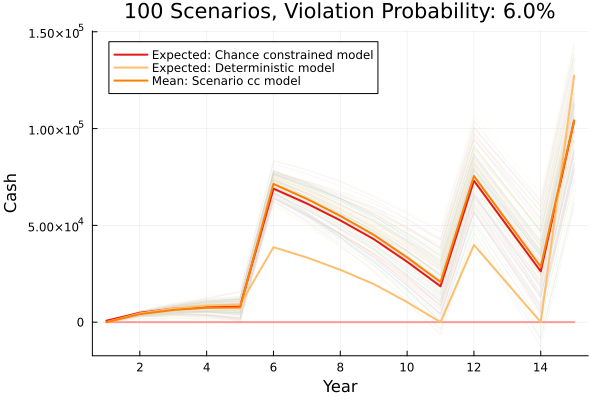

In [10]:
# Cash amount in every year
cash_scenarios_scen = [cash_scen_ind[s,j] for j in J, s in S]

# Calculate number of violations of liquidity constraint
n_violations = number_of_violations(cash_scenarios_scen)

#Plot
plot(label=false,
    xlabel="Year", 
    ylabel="Cash",
    title="$(nS) Scenarios, Violation Probability: $(100*n_violations/nS)%")

plot!(cash_scenarios_scen, alpha=0.2, label=false, palette=:Pastel2)
plot!(1:15, linewidth=2, label=false, palette=:Paired)
plot!([cash_chance[j] for j in J], linewidth=2,label="Expected: Chance constrained model")
plot!([cash_det[j] for j in J], linewidth=2,label="Expected: Deterministic model")
plot!(cash_scen_mean, linewidth=2,label="Mean: Scenario cc model")

## Scenario-Based Joint Chance Constraints
To make sure only $p$% of scenarios total (not scenarios per year) violate the liquidity constraint, we must use a joint chance constraint. In the scenario-based model, this means having only one pair of $u,v$ per scenario $s\in S$.
\begin{align*}
    \max_{x,u,v}\; & K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{15}\sum_{i=1}^3\alpha_{ij}x_i - \sum_{s\in S}P_s\sum_{j=1}^{15}\beta_j^s\\
     \text{s.t. }  & K - \sum_{i=1}^3\gamma_ix_i + \sum_{j=1}^{k}\sum_{i=1}^3\alpha_{ij}x_i - \sum_{j=1}^{k}\beta_j^s + \color{blue}{u^s} \geq 0 \quad \forall k=1,\dots,15,\quad\forall s\in S \\
     &\;u^s \leq Mv^s \quad \forall k=1,\dots,15,\quad\forall s\in S \\
     &\sum_{s\in S} P_sv^s \leq 1-p \\
     &v^s \in \{0,1\},\; u^s \geq 0
\end{align*}

In [11]:
# implementing the model
M = 10^6 # big M
m_scen_joint = Model(HiGHS.Optimizer)
set_silent(m_scen_joint)

@variable(m_scen_joint, x[I]) # bond decision
@variable(m_scen_joint, v[s in S], Bin) # is scenario s violating liquidity constraint j?
@variable(m_scen_joint, u[s in S, j in J] >= 0) # by how much is scenario s violating liquidity constraint j?

@expression(m_scen_joint, cash_scen[s in S, k in J], K - sum(γ[i]*x[i] for i in I) + sum(α[i,j]*x[i] for i in I, j in 1:k) - sum(β_stoch[s,j] for j in 1:k) + u[s,k])

@constraint(m_scen_joint, [k in J, s in S], cash_scen[s,k] >= 0)
@constraint(m_scen_joint, [k in J, s in S], u[s,k] <= M*v[s])
@constraint(m_scen_joint, [k in J], sum(β_prob[s]*v[s] for s in S) <= 1-p)

@objective(m_scen_joint, Max, K - sum(γ[i]*x[i] for i in I) + sum(α[i,j]*x[i] for i in I, j in J) - sum(β_prob[s]*β_stoch[s,j] for j in J, s in S)) # optimize expected value over scenarios

optimize!(m_scen_joint)

# print solution
x_scen_joint         = round.(value.(x), digits=1)
cash_scen_joint      = round.(value.(cash_scen).-value.(u),digits=1)
cash_scen_mean_joint = round.([mean(cash_scen_joint[:,j]) for j in J], digits=1)# mean cash over scenarios

println("x = ",               [x_scen_joint[i] for i in I])
println("objective value = ", round.(objective_value(m_scen_joint), digits=1))
println("expected cash = ",   cash_scen_mean_joint) 

x = [66.6, 72.3, 97.5]
objective value = 102583.6
expected cash = [1212.2, 5258.3, 7310.6, 8343.0, 8390.7, 73044.3, 65146.6, 56228.7, 46352.5, 34498.8, 21654.4, 75698.1, 52151.8, 28620.9, 102583.6]


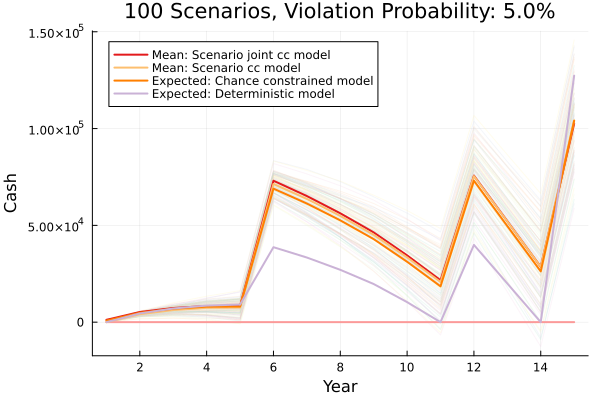

In [12]:
# Cash amount in every year
cash_scenarios_scen_joint = [cash_scen_joint[s,j] for j in J, s in S]

# Calculate number of violations of liquidity constraint
n_violations = number_of_violations(cash_scenarios_scen_joint)

#Plot
plot(label=false,
    xlabel="Year", 
    ylabel="Cash",
    title="$(nS) Scenarios, Violation Probability: $(100*n_violations/nS)%")

plot!(cash_scenarios_scen, alpha=0.2,label=false,palette=:Pastel2)
plot!(1:15, linewidth=2, label=false,palette=:Paired)
plot!([cash_scen_mean_joint[j] for j in J], linewidth=2,label="Mean: Scenario joint cc model")
plot!(cash_scen_mean,                       linewidth=2,label="Mean: Scenario cc model")
plot!([cash_chance[j] for j in J],          linewidth=2,label="Expected: Chance constrained model")
plot!([cash_det[j] for j in J],             linewidth=2,label="Expected: Deterministic model")